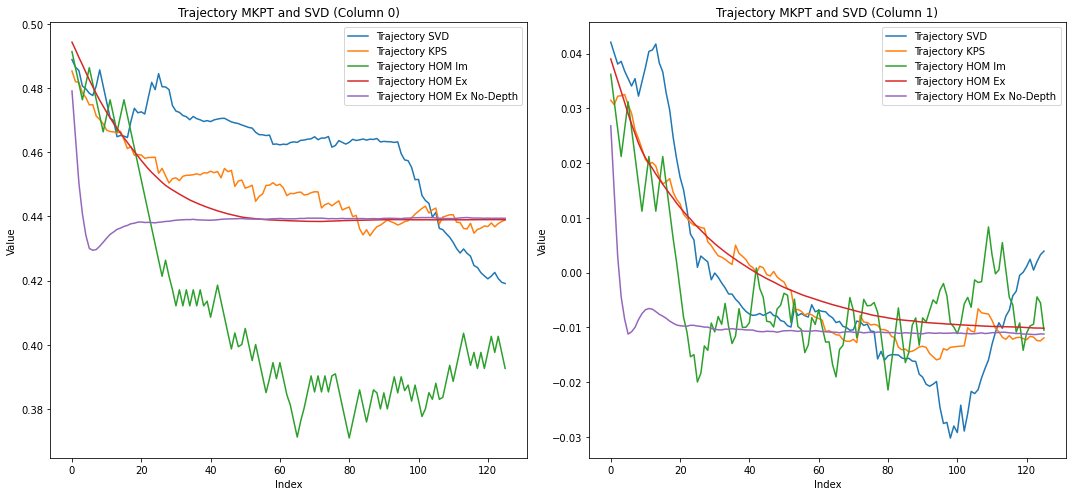

In [101]:
import numpy as np
import matplotlib.pyplot as plt

# Load the data
traj_kps_0 = np.load("trajectory_kps.npy")[:, 0]
traj_kps_sp_lg_0 = np.load("trajectory_kps_sp+lg.npy")[:, 0]
traj_svd_0 = np.load("trajectory_svd.npy")[:, 0]
traj_hom_i_0 = np.load("trajectory_hom_implicit.npy")[:, 0]
traj_hom_e_0 = np.load("trajectory_hom.npy")[:, 0]
traj_hom_no_depth_0 = np.load("trajectory_hom_no_depth.npy")[:, 0]

traj_kps_1 = np.load("trajectory_kps.npy")[:, 1]
traj_kps_sp_lg_1 = np.load("trajectory_kps_sp+lg.npy")[:, 1]
traj_svd_1 = np.load("trajectory_svd.npy")[:, 1]
traj_hom_i_1 = np.load("trajectory_hom_implicit.npy")[:, 1]
traj_hom_e_1 = np.load("trajectory_hom.npy")[:, 1]
traj_hom_no_depth_1 = np.load("trajectory_hom_no_depth.npy")[:, 1]

# Generate an x-axis
x = np.arange(len(traj_kps_0))

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 7))

# Plot the first set of data
axs[0].plot(x, traj_svd_0, label='Trajectory SVD')
axs[0].plot(x, traj_kps_0, label='Trajectory KPS')
axs[0].plot(x, traj_hom_i_0, label='Trajectory HOM Im')
axs[0].plot(x, traj_hom_e_0, label='Trajectory HOM Ex')
axs[0].plot(x, traj_hom_no_depth_0, label='Trajectory HOM Ex No-Depth')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Value')
axs[0].set_title('Trajectory MKPT and SVD (Column 0)')
axs[0].legend()

# Plot the second set of data
axs[1].plot(x, traj_svd_1, label='Trajectory SVD')
axs[1].plot(x, traj_kps_1, label='Trajectory KPS')
axs[1].plot(x, traj_hom_i_1, label='Trajectory HOM Im')
axs[1].plot(x, traj_hom_e_1, label='Trajectory HOM Ex')
axs[1].plot(x, traj_hom_no_depth_1, label='Trajectory HOM Ex No-Depth')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Value')
axs[1].set_title('Trajectory MKPT and SVD (Column 1)')
axs[1].legend()

# Show the plot
plt.tight_layout()
plt.show()


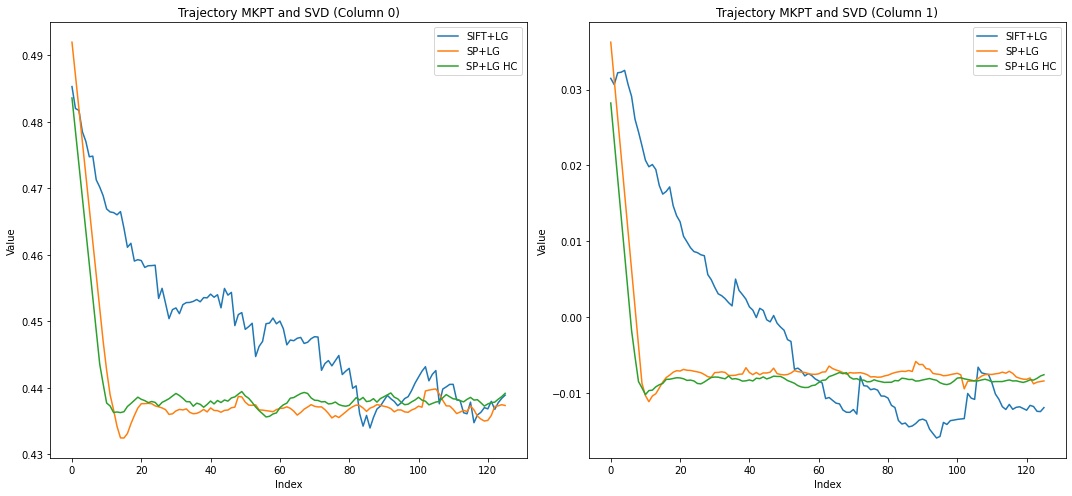

In [105]:
import numpy as np
import matplotlib.pyplot as plt

# Load the data
traj_kps_0 = np.load("trajectory_kps.npy")[:, 0]
traj_kps_sp_lg_0 = np.load("trajectory_kps_sp+lg.npy")[:, 0]
traj_kps_sp_lg_hc_0 = np.load("trajectory_kps_highest_confidence.npy")[:, 0]

traj_kps_1 = np.load("trajectory_kps.npy")[:, 1]
traj_kps_sp_lg_1 = np.load("trajectory_kps_sp+lg.npy")[:, 1]
traj_kps_sp_lg_hc_1 = np.load("trajectory_kps_highest_confidence.npy")[:, 1]
# Generate an x-axis
x = np.arange(len(traj_kps_0))

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 7))

# Plot the first set of data
axs[0].plot(x, traj_kps_0, label='SIFT+LG')
axs[0].plot(x, traj_kps_sp_lg_0, label='SP+LG')
axs[0].plot(x, traj_kps_sp_lg_hc_0, label='SP+LG HC')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Value')
axs[0].set_title('Trajectory MKPT and SVD (Column 0)')
axs[0].legend()

# Plot the second set of data
axs[1].plot(x, traj_kps_1, label='SIFT+LG')
axs[1].plot(x, traj_kps_sp_lg_1, label='SP+LG')
axs[1].plot(x, traj_kps_sp_lg_hc_1, label='SP+LG HC')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Value')
axs[1].set_title('Trajectory MKPT and SVD (Column 1)')
axs[1].legend()

# Show the plot
plt.tight_layout()
plt.show()


In [66]:
from scipy.spatial.transform import Rotation as R
import json
import numpy as np

def create_homogeneous_matrix(xyz, quaternion):
    rotation_matrix = R.from_quat(quaternion).as_matrix()
    T = np.eye(4) 
    T[:3, :3] = rotation_matrix
    T[:3, 3] = xyz 

    return T

def pose_inv(pose):
    R = pose[:3, :3]
    T = np.eye(4)
    T[:3, :3] = R.T
    T[:3, 3] = - R.T @ np.ascontiguousarray(pose[:3, 3])
    return T


K = np.load("handeye/intrinsics_d415.npy")
T_WC = np.load("handeye/T_WC_head.npy")
DIR = "pencil_sharpener"

with open(f"experiments/{DIR}/demo_bottlenecks.json") as f:
    dbn = json.load(f)
    
T_GRIP_EEF = create_homogeneous_matrix([0, 0, 0.136], [0, 0, 0, 1])
demo_waypoints = np.vstack([dbn[key] for key in dbn.keys()])
demo_waypoints

array([[ 4.96677473e-01,  4.12016053e-02,  4.55253290e-01,
        -9.97659431e-01,  1.90250200e-02, -6.39123210e-02,
         1.51302073e-02],
       [ 4.40391932e-01,  1.35902490e-01,  2.97994343e-01,
         9.97853233e-01, -1.53176029e-02, -6.36702943e-02,
         6.25089375e-04],
       [ 4.36594966e-01, -9.55230986e-02,  2.84233720e-01,
        -9.83311430e-01, -1.57137508e-02,  7.59195973e-03,
         1.81091334e-01],
       [ 4.40391932e-01,  5.99024898e-02,  2.97994343e-01,
         9.97853233e-01, -1.53176029e-02, -6.36702943e-02,
         6.25089375e-04]])

In [67]:
with open(f"experiments/{DIR}/rearrange.json") as f:
    dbn = json.load(f)
    rearrange_waypopints = np.vstack([dbn[key] for key in dbn.keys()])
from trajectory_utils import apply_transformation_to_waypoints
live_waypoints = apply_transformation_to_waypoints(rearrange_waypopints, np.eye(4), project3D=True)
rearrange_waypopints[0].tolist(), live_waypoints[0]

([0.45931572361010736,
  0.0123992983923882,
  0.2828484408140383,
  0.9973796349171662,
  0.05747578692881908,
  0.0386939072948877,
  0.020812960089042848],
 [0.45931572361010736,
  0.0123992983923882,
  0.2828484408140383,
  0.9973796349171661,
  0.05747578692881907,
  0.0386939072948877,
  0.020812960089042844])

In [68]:
point_2Ds = []

for i in range(len(demo_waypoints)):
    point3d = pose_inv(T_WC)  @ create_homogeneous_matrix(demo_waypoints[i, :3], demo_waypoints[i, 3:]) @ T_GRIP_EEF
    
    # Project the 3D point onto the image plane
    point_image_homogeneous = np.dot(K, point3d[:3, 3])
    
    # Normalize the coordinates to get the 2D image point
    point_2D = point_image_homogeneous[:2] / point_image_homogeneous[2]

    point_2Ds.append(point_2D)

point_2Ds

[array([776.06348678, 320.86510983]),
 array([855.61615526, 431.30868952]),
 array([629.87388963, 443.07371057]),
 array([762.18723527, 430.3861315 ])]

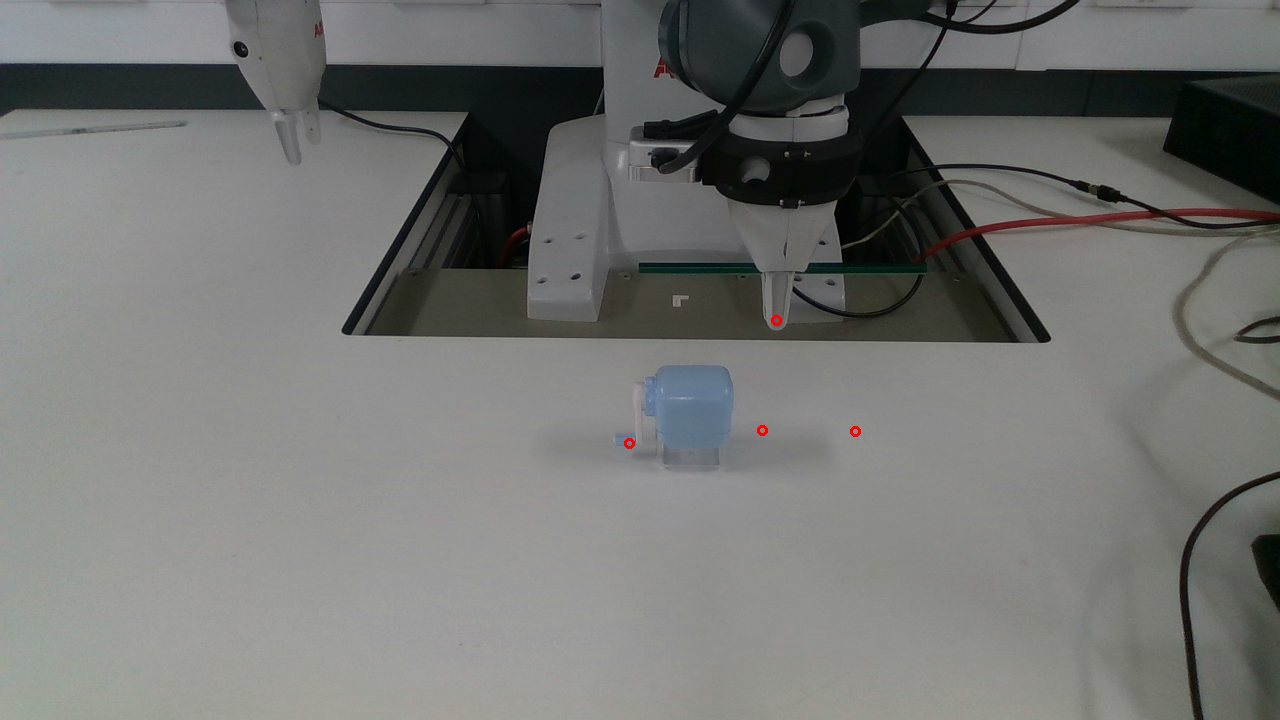

In [69]:
from PIL import Image, ImageDraw

head_rgb = Image.open(f"experiments/{DIR}/demo_head_rgb.png")

# Create a drawing context
draw = ImageDraw.Draw(head_rgb)

for point_2D in point_2Ds:
    x, y, r = point_2D[0], point_2D[1], 5
    # Draw the circle (ellipse) with bounding box [(x-r, y-r), (x+r, y+r)]
    draw.ellipse((x-r, y-r, x+r, y+r), outline="red", width=3)


# Save or show the image
head_rgb

In [70]:
T_wrist_head = np.array( [[ 0.03747486,  0.9916625,  -0.12329277,  0.06823914],
  [-0.47062567,  0.12635414,  0.87323886, -0.10383146],
  [ 0.8815368,   0.02530024,  0.47143695,  0.2750577 ],
  [ 0.,          0.,          0.,          1.        ]]
)

T_camera_eef = np.load("handeye/T_C_EEF_wrist_l.npy")
T_eef_world = create_homogeneous_matrix(demo_waypoints[0, :3], demo_waypoints[0, 3:])
T_camera_world = T_camera_eef @ T_eef_world

pose_inv(T_wrist_head) @ T_camera_world

array([[ 0.02658023, -0.5491851 , -0.83527794,  0.08122112],
       [-0.96967821,  0.18889726, -0.15505478, -0.52633836],
       [ 0.2429355 ,  0.8140722 , -0.52751191,  0.32171385],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [71]:
T_camera_world @ T_wrist_head 

array([[-0.17416423, -0.97694116,  0.12350217, -0.59783187],
       [-0.54135004,  0.1997571 ,  0.81672347, -0.04945908],
       [-0.82256122,  0.0753861 , -0.5636577 ,  0.23065564],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [72]:
T_WC = np.load("handeye/T_WC_head.npy")
T_WC @ pose_inv(T_wrist_head)

array([[ 0.64246282, -0.66711954, -0.37708494,  0.99931101],
       [ 0.04668669, -0.457086  ,  0.88819635, -0.33981611],
       [-0.76489337, -0.58823797, -0.26251517,  0.67683488],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [73]:
T_GRIP_EEF = create_homogeneous_matrix([0, 0, 0.136], [0, 0, 0, 1])

pose_inv(T_GRIP_EEF)

array([[ 1.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  1.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  1.   , -0.136],
       [ 0.   ,  0.   ,  0.   ,  1.   ]])

In [74]:

with open(f"experiments/{DIR}/demo_bottlenecks.json") as f:
    dbn = json.load(f)
    
demo_waypoints = np.vstack([dbn[key] for key in dbn.keys()])
demo_waypoints

K_wrist = np.load("handeye/intrinsics_d405.npy")
T_C_EEF = np.load("handeye/T_C_EEF_wrist_l.npy")
T_GRIP_EEF = create_homogeneous_matrix([0, 0, 0.136], [0, 0, 0, 1])
point_2Ds = []
T_EEF_World = create_homogeneous_matrix(demo_waypoints[0, :3], demo_waypoints[0, 3:])

for i in range(len(demo_waypoints)):

    point3d = pose_inv(T_C_EEF) @ pose_inv(T_EEF_World) @ create_homogeneous_matrix(demo_waypoints[i, :3], demo_waypoints[i, 3:]) @ T_GRIP_EEF
    # Project the 3D point onto the image plane
    point_image_homogeneous = np.dot(K_wrist, point3d[:3, 3])
    print(point3d)
    # Normalize the coordinates to get the 2D image point
    point_2D = point_image_homogeneous[:2] / point_image_homogeneous[2]

    point_2Ds.append(point_2D)

wrist_rgb = Image.open(f"experiments/{DIR}/demo_wrist_rgb.png")

# Create a drawing context
draw = ImageDraw.Draw(wrist_rgb)

for point_2D in point_2Ds:
    x, y, r = point_2D[0], point_2D[1], 5
    # Draw the circle (ellipse) with bounding box [(x-r, y-r), (x+r, y+r)]
    draw.ellipse((x-r, y-r, x+r, y+r), outline="red", width=3)

print(point_2Ds)
# Save or show the image
wrist_rgb.show()

[[-0.99950681  0.02947871 -0.01082309  0.0082311 ]
 [-0.03010772 -0.99752916  0.0634752   0.07647842]
 [-0.00892518  0.06376976  0.99792473  0.09797773]
 [ 0.          0.          0.          1.        ]]
[[-0.96997936  0.01977762  0.2423817   0.11793966]
 [-0.01217462 -0.99938694  0.03282574  0.17152471]
 [ 0.24288232  0.02888938  0.96962549  0.24026998]
 [ 0.          0.          0.          1.        ]]
[[-0.99103828  0.00431886  0.13350836  0.10617058]
 [ 0.04816623 -0.92068493  0.38732322 -0.01111361]
 [ 0.12459193  0.39028273  0.91222598  0.25392598]
 [ 0.          0.          0.          1.        ]]
[[-0.96997936  0.01977762  0.2423817   0.1171697 ]
 [-0.01217462 -0.99938694  0.03282574  0.09557689]
 [ 0.24288232  0.02888938  0.96962549  0.24297848]
 [ 0.          0.          0.          1.        ]]
[array([454.97064198, 571.72707746]), array([630.55423901, 542.97290019]), array([599.15925684, 216.2843791 ]), array([626.82528941, 404.76565406])]


In [84]:
import numpy as np
from scipy.optimize import minimize
import cv2

def project_points(X, K, R, t):
    """ Project 3D points X to 2D points using camera intrinsics K, rotation R, and translation t. """
    X_cam = R @ X + t
    X_cam = X_cam / X_cam[2]  # Normalize by depth
    uv = K @ X_cam
    return uv[:2]

def reprojection_error(params, X_world, uv_pixel, K):
    """ Compute the reprojection error. """
    # Extract rotation vector and translation vector from params
    rvec = params[:3]
    tvec = params[3:]

    # Convert rotation vector to rotation matrix
    R, _ = cv2.Rodrigues(rvec)

    # Project points
    uv_proj = project_points(X_world, K, R, tvec)

    # Compute error
    error = uv_proj - uv_pixel
    return np.sum(error**2)

# 3D point in world coordinates (example values)
X_world = demo_waypoints[0, :3]

# Corresponding pixel coordinates in image
uv_pixel = np.array([652, 287])

# Initial guess for rotation (rvec) and translation (tvec)
initial_guess = np.zeros(6)

# Perform optimization to minimize the reprojection error
result = minimize(reprojection_error, initial_guess, args=(X_world, uv_pixel, K), method='BFGS')

# Extract optimized rotation and translation
rvec_optimized = result.x[:3]
tvec_optimized = result.x[3:]

# Convert optimized rotation vector to matrix
R_optimized, _ = cv2.Rodrigues(rvec_optimized)

print("Optimized Rotation Matrix:\n", R_optimized)
print("Optimized Translation Vector:\n", tvec_optimized)

point_2Ds = [[652, 287]]
for i in range(len(demo_waypoints)):
    R, _ = cv2.Rodrigues(rvec_optimized)
    uv_proj = project_points(X_world, K, R, tvec_optimized)

    point_2Ds.append(point_2D)
    break

wrist_rgb = Image.open(f"experiments/{DIR}/demo_wrist_rgb.png")

# Create a drawing context
draw = ImageDraw.Draw(wrist_rgb)

for point_2D in point_2Ds:
    x, y, r = point_2D[0], point_2D[1], 5
    # Draw the circle (ellipse) with bounding box [(x-r, y-r), (x+r, y+r)]
    draw.ellipse((x-r, y-r, x+r, y+r), outline="red", width=3)

print(point_2Ds)
# Save or show the image
wrist_rgb.show()


Optimized Rotation Matrix:
 [[ 0.54561887  0.15026126  0.82445231]
 [-0.11720431  0.98780736 -0.10246839]
 [-0.82979709 -0.04072068  0.5565776 ]]
Optimized Translation Vector:
 [-0.64044619 -0.07871545  2.06754796]
[[652, 287], array([626.82528941, 404.76565406])]


In [196]:
create_homogeneous_matrix([0.58381608, -0.00932566, 0.3015399], [0, 0, 0, 1])


array([[ 1.        ,  0.        ,  0.        ,  0.58381608],
       [ 0.        ,  1.        ,  0.        , -0.00932566],
       [ 0.        ,  0.        ,  1.        ,  0.3015399 ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

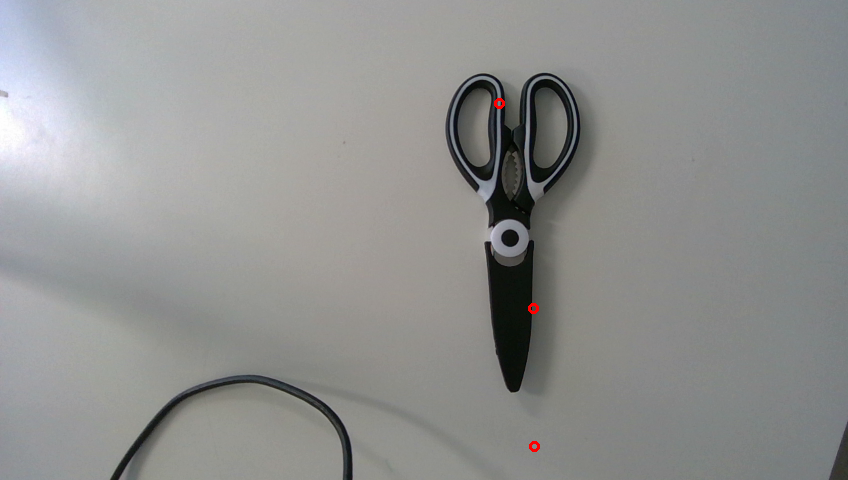

In [189]:
wrist_rgb = Image.open(f"experiments/{DIR}/live_d405_rgb.png")

draw = ImageDraw.Draw(wrist_rgb)

for point_2D in point_2Ds:
    x, y, r = point_2D[0], point_2D[1], 5
    # Draw the circle (ellipse) with bounding box [(x-r, y-r), (x+r, y+r)]
    draw.ellipse((x-r, y-r, x+r, y+r), outline="red", width=3)


# Save or show the image
wrist_rgb

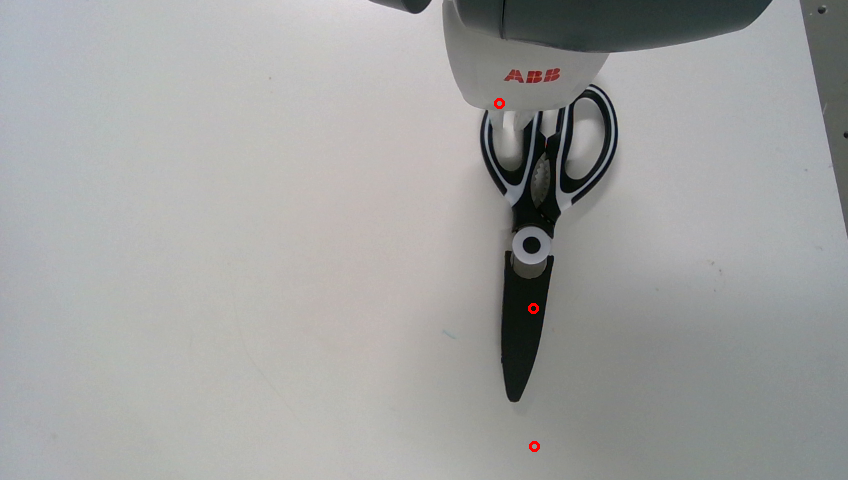

In [172]:
wrist_rgb = Image.open(f"experiments/{DIR}/live_right_in_view.png")

draw = ImageDraw.Draw(wrist_rgb)

for point_2D in point_2Ds:
    x, y, r = point_2D[0], point_2D[1], 5
    # Draw the circle (ellipse) with bounding box [(x-r, y-r), (x+r, y+r)]
    draw.ellipse((x-r, y-r, x+r, y+r), outline="red", width=3)


# Save or show the image
wrist_rgb

In [58]:
from PIL import Image, ImageDraw

head_rgb = Image.open(f"experiments/{DIR}/demo_head_rgb.png")

# Create a drawing context
draw = ImageDraw.Draw(head_rgb)

for point_2D in [[738, 466], [715, 635], [800, 910]]:
    x, y, r = point_2D[0], point_2D[1], 5
    # Draw the circle (ellipse) with bounding box [(x-r, y-r), (x+r, y+r)]
    draw.ellipse((x-r, y-r, x+r, y+r), outline="red", width=3)


# Save or show the image
head_rgb

NameError: name 'DIR' is not defined